# U-Net Segmentation

### Data extraction

In [67]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 
import re
import cv2
import pydicom
import nibabel as nib
from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
tf.config.run_functions_eagerly(True)

In [2]:
metadata_path = "/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv"

train_metadata = pd.read_csv(metadata_path)
train_metadata.head()

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


In [3]:
segmentations_path = "/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations"

segmentations = os.listdir(segmentations_path)
segmentations = [int(os.path.splitext(segmentation)[0]) for segmentation in segmentations]

print(f"Total number of series id that are supported with a segmentation file: {len(segmentations)}")

Total number of series id that are supported with a segmentation file: 206


In [4]:
series = train_metadata["series_id"].tolist()

matched_series = []

for segmentation in segmentations:
    if segmentation in series:
        matched_series.append(segmentation)
    else:
        continue

len(matched_series)

206

In [5]:
patients_segment = train_metadata[train_metadata["series_id"].isin(matched_series)].reset_index(drop=True)
patients_with_segmentations = patients_segment["patient_id"].unique()
patients_segment

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10217,16066,208.00,0
3,10228,30522,145.00,0
4,10228,40471,291.00,0
...,...,...,...,...
201,65504,55928,144.00,0
202,7642,778,183.00,0
203,8848,41663,238.00,0
204,8848,7384,367.00,0


Now we had mapped successfully the patient id and series id from the training data that we will use for segmentation purpose

### Data cleaning -> DICOM and NIFTII

In [6]:
def extract_number_from_path(path):
    match = re.search(r'(\d+)\.dcm$', path)
    if match:
        return int(match.group(1))
    return 0

def get_data_for_3d_volumes(data, dcm_path, niftii_path):

    data_to_merge = data[["patient_id", "series_id"]]
    
    total_paths = []
    patient_ids = []
    series_ids = []
    seg_path = []
    
    for patient_id in range(len(data_to_merge)):
    
        p_id = str(data_to_merge["patient_id"][patient_id]) + "/" + str(data_to_merge["series_id"][patient_id])
        str_imgs_path = dcm_path + p_id + '/'
        
        seg_mask_paths = niftii_path + str(data_to_merge["series_id"][patient_id]) + ".nii"
        seg_path.append(seg_mask_paths)
        
        patient_img_paths = []

        for file in glob(str_imgs_path + '/*'):
            patient_img_paths.append(file)
        
        
        sorted_file_paths = sorted(patient_img_paths, key=extract_number_from_path)
        total_paths.append(sorted_file_paths)
        patient_ids.append(data_to_merge["patient_id"][patient_id])
        series_ids.append(data_to_merge["series_id"][patient_id])
    
    final_data = pd.DataFrame(list(zip(patient_ids, series_ids, total_paths, seg_path)),
               columns =["patient_id","series_id", "patient_paths", "patient_segmentation"])
    
    return final_data

In [7]:
dcm_path = "/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/"
niftii_path = "/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations/"

cleaned_data = get_data_for_3d_volumes(patients_segment, dcm_path, niftii_path)

In [10]:
cleaned_data.head()

,patient_id,series_id,patient_paths,patient_segmentation
0,10004,21057,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,/kaggle/input/rsna-2023-abdominal-trauma-detec...
1,10004,51033,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,/kaggle/input/rsna-2023-abdominal-trauma-detec...
2,10217,16066,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,/kaggle/input/rsna-2023-abdominal-trauma-detec...
3,10228,30522,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,/kaggle/input/rsna-2023-abdominal-trauma-detec...
4,10228,40471,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,/kaggle/input/rsna-2023-abdominal-trauma-detec...


In [11]:
def window_converter(image, window_width=400, window_level=50):      
    img_min = window_level - window_width // 2
    img_max = window_level + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    #image = (image / image.max() * 255).astype(np.float64)
    return window_image

def transform_to_hu(medical_image, image):
    meta_image = pydicom.dcmread(medical_image)
    intercept = meta_image.RescaleIntercept
    slope = meta_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    # Correct DICOM pixel_array if PixelRepresentation == 1.
        pixel_array = dcm.pixel_array
        if dcm.PixelRepresentation == 1:
            bit_shift = dcm.BitsAllocated - dcm.BitsStored
            dtype = pixel_array.dtype 
            pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift
        return pixel_array

def resize_img(img_paths, target_size=(128, 128)):
        volume_shape = (target_size[0], target_size[1], len(img_paths)) 
        volume = np.zeros(volume_shape, dtype=np.float64)
        for i, image_path in enumerate(img_paths):
            image = pydicom.read_file(image_path)
            image = standardize_pixel_array(image)
            hu_image = transform_to_hu(image_path, image)
            window_image = window_converter(hu_image)
            image = cv2.resize(window_image, target_size)
            volume[:,:,i] = image
        return volume
    
def normalize_volume(resized_volume):
    original_shape = resized_volume.shape
    flattened_image = resized_volume.reshape((-1,))
    scaler = preprocessing.MinMaxScaler()
    normalized_flattened_image = scaler.fit_transform(flattened_image.reshape((-1, 1)))
    normalized_volume_image = normalized_flattened_image.reshape(original_shape)
    return normalized_volume_image

def create_3D_segmentations(filepath, target_size, downsample_rate=1):
    img = nib.load(filepath).get_fdata()
    img = np.transpose(img, [2, 1, 0])
    img = np.rot90(img, -1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [2, 1, 0])
    img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    
    resized_images = []

    for i in range(img.shape[2]):
        resized_img = cv2.resize(img[:, :, i], target_size)
        resized_images.append(resized_img)
    
    resized_3D_mask = np.stack(resized_images, axis=2)
    
    return resized_3D_mask

def generate_patient_processed_data(list_img_paths, list_seg_paths, target_size=(128,128)):

    height = target_size[0]
    width = target_size[1]
    depth = len(list_img_paths)

    volume_array = np.zeros((height, width, depth), dtype=np.float64)

    print("Initializing data preprocessing with the following dimensions-> Volumes:{}".format(volume_array.shape))

    resized_images = resize_img(list_img_paths, target_size=target_size)
    normalized_siz_volume = normalize_volume(resized_images)
    volume_array = normalized_siz_volume
    volume_mask = create_3D_segmentations(list_seg_paths, target_size=target_size)

    return volume_array, volume_mask

In [36]:
volume_dcm, volume_nii = generate_patient_processed_data(cleaned_data["patient_paths"][0], cleaned_data["patient_segmentation"][0])

Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 1022)


In [37]:
volume_dcm.shape, volume_nii.shape

((128, 128, 1022), (128, 128, 1022))

In [16]:
def segmentation_visualization(volume, volume_seg, slice_dcm):
    
    fig = plt.figure(figsize=(14,14), constrained_layout=True)

    ax1 = fig.add_subplot(131)
    ax1.imshow(volume[slice_dcm,:,:], cmap = 'gray')

    ax2 = fig.add_subplot(132)
    ax2.imshow(volume_seg[slice_dcm,:,:], cmap = 'gray')

    ax3 = fig.add_subplot(133)
    ax3.imshow(volume[slice_dcm,:,:]*np.where(volume_seg[slice_dcm,:,:]>0,1,0), cmap = 'gray')
    ax3.set_title('Overlay of Original and Segmented', fontsize=14)
    plt.show()

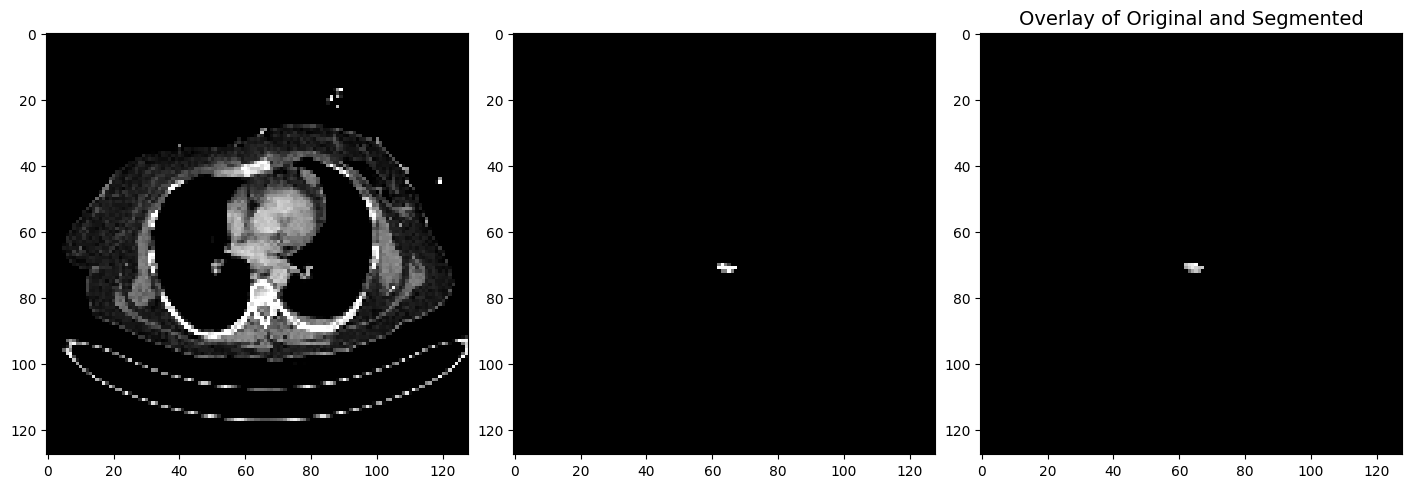

In [17]:
segmentation_visualization(transposed_volume_dcm, transpose_volume_nii, slice_dcm=100)

### Train & Test split and categorical labels

### Segmentations labels


* i. 0 = background
* ii. 1 = liver
* iii. 2 = spleen
* iv. 3 = left kidney
* v. 4 = right kidney
* vi. 5 = bowel

In [39]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

n, h, w = volume_nii.shape
train_masks_reshaped = volume_nii.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
train_masks_encoded_original_shape.shape

(128, 128, 1022)

In [48]:
np.unique(train_masks_reshaped_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [43]:
transposed_volume_dcm = np.transpose(volume_dcm, (2, 0, 1))
transpose_volume_nii = np.transpose(train_masks_encoded_original_shape, (2, 0, 1))

transposed_volume_dcm = np.expand_dims(transposed_volume_dcm, axis=3)
transpose_volume_nii = np.expand_dims(transpose_volume_nii, axis=3)

In [61]:
number_classes = len(np.unique(train_masks_reshaped_encoded))

X_train , X_test, y_train, y_test = train_test_split(transposed_volume_dcm, transpose_volume_nii, test_size = 0.10, random_state = 0)


train_masks_cat = to_categorical(y_train, num_classes=number_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], number_classes))


test_masks_cat = to_categorical(y_test, num_classes=number_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], number_classes))

In [58]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(train_masks_reshaped_encoded),
                                                 y = train_masks_reshaped_encoded)

print("Class weights are...:", class_weights)

Class weights are...: [5.93480625e-02 1.81973222e+02 1.02812457e+02 1.55351889e+02
 1.97544539e+00 6.13619466e+01 3.42632453e+02 5.16803951e+04
 1.83155564e+01 1.11540421e+03 4.39770771e+01 1.75518323e+04
 3.38001276e+01 6.08004648e+03 6.48526988e+01 3.42986178e+01
 1.69135838e+04 2.21992175e+00]


## Custom loss function

In [60]:
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):
        true = K.cast(true, K.floatx())
        pred = K.cast(pred, K.floatx())

        axis = -1 #if channels last 
          #axis=  1 #if channels first


          #argmax returns the index of the element with the greatest value
          #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
              #if your loss is sparse, use only true as classSelectors

          #considering weights are ordered by class, for each class
          #true(1) if the class index is equal to the weight index 
          #weightsList = tf.cast(weightsList, tf.int64)
        classSelectors = [K.equal(tf.cast(i, tf.int64), tf.cast(classSelectors, tf.int64)) for i in range(len(weightsList))]

          #casting boolean to float for calculations  
          #each tensor in the list contains 1 where ground true class is equal to its index 
          #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

          #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

          #sums all the selections
          #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


          #make sure your originalLossFunc only collapses the class axis
          #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

## U-Net model architecture

In [59]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
    x = tf.keras.layers.concatenate([x, conv_features])
   # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x


def build_unet_model():
    # inputs
    units = 128
    inputs = tf.keras.layers.Input(shape=(units,units,1))
   # encoder: contracting path - downsample
   # 1 - downsample
    f1, p1 = downsample_block(inputs, units/4)
   # 2 - downsample
    f2, p2 = downsample_block(p1, units/2)
   # 3 - downsample
    f3, p3 = downsample_block(p2, units*1)
   # 4 - downsample
    f4, p4 = downsample_block(p3, units*2)
   # 5 - bottleneck
    bottleneck = double_conv_block(p4, units*4)
   # decoder: expanding path - upsample
   # 6 - upsample
    u6 = upsample_block(bottleneck, f4, units*2)
   # 7 - upsample
    u7 = upsample_block(u6, f3, units*1)
   # 8 - upsample
    u8 = upsample_block(u7, f2, units/2)
   # 9 - upsample
    u9 = upsample_block(u8, f1, units/4)
   # outputs
    outputs = tf.keras.layers.Conv2D(18, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [62]:
Unet = build_unet_model()
Unet.compile(optimizer='adam', loss=weightedLoss(tf.keras.losses.categorical_crossentropy, class_weights), metrics=['accuracy'])

In [63]:
Unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_38[0][0]']              
                                )                                                             

In [68]:
history = Unet.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
58/58 [==============================] - 15s 242ms/step - loss: 2.8273 - accuracy: 0.0128 - val_loss: 2.8887 - val_accuracy: 0.0049
Epoch 2/50
58/58 [==============================] - 14s 233ms/step - loss: 2.5303 - accuracy: 0.1388 - val_loss: 2.5464 - val_accuracy: 0.7585
Epoch 3/50
58/58 [==============================] - 14s 234ms/step - loss: 2.2057 - accuracy: 0.6827 - val_loss: 2.3126 - val_accuracy: 0.6933
Epoch 4/50
58/58 [==============================] - 13s 232ms/step - loss: 2.0698 - accuracy: 0.6730 - val_loss: 2.1771 - val_accuracy: 0.6571
Epoch 5/50
58/58 [==============================] - 13s 227ms/step - loss: 1.8794 - accuracy: 0.6839 - val_loss: 2.0588 - val_accuracy: 0.6807
Epoch 6/50
58/58 [==============================] - 14s 239ms/step - loss: 1.6546 - accuracy: 0.6867 - val_loss: 1.7910 - val_accuracy: 0.6820
Epoch 7/50
58/58 [==============================] - 13s 227ms/step - loss: 1.4415 - accuracy: 0.7030 - val_loss: 1.6657 - val_accuracy: 0.6959

In [28]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

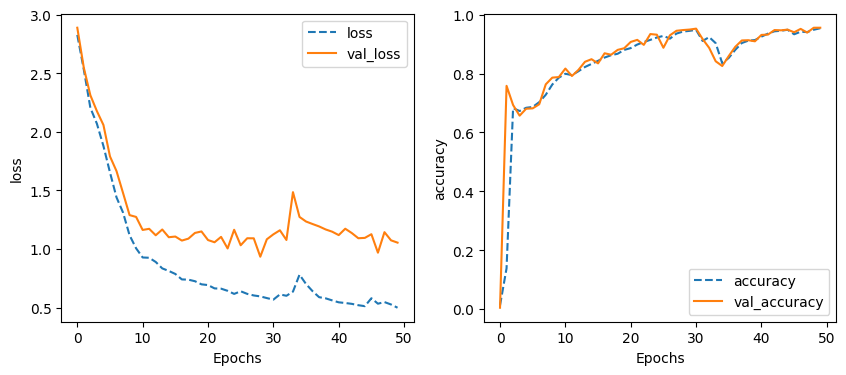

In [69]:
training_plot(['loss', 'accuracy'], history);